In [1]:
import pandas as pd
import numpy as np
import random

class MarkovTraceGenerator:
    def __init__(self, app_name="SyntheticApp"):
        self.app_name = app_name
        self.transition_matrix = {}
        self.interarrival_distributions = {}
        self.length_distributions = {}
        self.protocols = []

    def set_model(self, transition_matrix, interarrival_dists, length_dists):
        self.transition_matrix = transition_matrix
        self.interarrival_distributions = interarrival_dists
        self.length_distributions = length_dists
        self.protocols = list(transition_matrix.keys())

    def generate(self, n_packets=500, source="172.30.1.1", destination="172.30.1.250"):
        rows = []
        current_proto = random.choice(self.protocols)
        current_time = 0.0

        for i in range(n_packets):
            # Pick length from empirical distribution
            length = int(random.choice(self.length_distributions[current_proto]))

            # Append row
            rows.append({
                "App name": self.app_name,
                "No.": i + 1,
                "Time": round(current_time, 6),
                "Source": source,
                "Destination": destination,
                "Protocol": current_proto,
                "Length": length
            })

            # Sample next protocol
            if current_proto in self.transition_matrix:
                next_proto = random.choices(
                    list(self.transition_matrix[current_proto].keys()),
                    weights=self.transition_matrix[current_proto].values(),
                    k=1
                )[0]
            else:
                next_proto = random.choice(self.protocols)

            # Sample next inter-arrival
            if next_proto in self.interarrival_distributions:
                delta = random.choice(self.interarrival_distributions[next_proto])
            else:
                delta = np.random.exponential(scale=1.0)  # fallback
            current_time += delta

            current_proto = next_proto

        return pd.DataFrame(rows)





In [ ]:
if __name__ == "__main__":
    # ---------- eMBB MODEL ----------
    embb_gen = MarkovTraceGenerator(app_name="eMBB_Synthetic")
    embb_gen.set_model(
        transition_matrix={
            "DNS": {"QUIC": 0.7, "TCP": 0.3},
            "QUIC": {"QUIC": 0.7, "TCP": 0.2, "DNS": 0.1},
            "TCP": {"TCP": 0.6, "QUIC": 0.3, "DNS": 0.1}
        },
        interarrival_dists={
            "DNS": np.random.exponential(scale=5, size=1000).tolist(),   # mean ~5 ms
            "QUIC": np.random.exponential(scale=50, size=1000).tolist(), # mean ~50 ms
            "TCP": np.random.exponential(scale=20, size=1000).tolist()   # mean ~20 ms
        },
        length_dists={
            "DNS": [64, 128],
            "QUIC": [800, 1200, 1500],
            "TCP": [200, 800, 1400]
        }
    )
    embb_trace = embb_gen.generate(n_packets=1000)
    embb_trace.to_csv("embb_markov.csv", index=False)

    # ---------- URLLC MODEL ----------
    urllc_gen = MarkovTraceGenerator(app_name="URLLC_Synthetic")
    urllc_gen.set_model(
        transition_matrix={
            "DNS": {"QUIC": 0.9, "TCP": 0.1},
            "QUIC": {"QUIC": 0.85, "DNS": 0.1, "TCP": 0.05},
            "TCP": {"QUIC": 0.8, "TCP": 0.2}
        },
        interarrival_dists={
            "DNS": np.random.exponential(scale=2, size=1000).tolist(),   # mean ~2 ms
            "QUIC": np.random.exponential(scale=0.5, size=1000).tolist(),# mean ~0.5 ms
            "TCP": np.random.exponential(scale=2, size=1000).tolist()    # mean ~2 ms
        },
        length_dists={
            "DNS": [64, 128],
            "QUIC": [64, 128, 256],
            "TCP": [128, 256, 512]
        }
    )
    urllc_trace = urllc_gen.generate(n_packets=1000)
    urllc_trace.to_csv("urllc_markov.csv", index=False)

    print("✅ Synthetic traces saved as embb_markov.csv and urllc_markov.csv")

✅ Synthetic traces saved as embb_markov.csv and urllc_markov.csv


### Fixed number of rows and fixed timing

In [3]:
import pandas as pd
import numpy as np
import random


class MarkovTraceGenerator:
    def __init__(self, app_name="SyntheticApp"):
        self.app_name = app_name
        self.transition_matrix = {}
        self.interarrival_distributions = {}
        self.length_distributions = {}
        self.protocols = []

    def set_model(self, transition_matrix, interarrival_dists, length_dists):
        """Set transition, interarrival, and length distributions manually"""
        self.transition_matrix = transition_matrix
        self.interarrival_distributions = interarrival_dists
        self.length_distributions = length_dists
        self.protocols = list(transition_matrix.keys())

    # ---------------- Mode 1: Random-timed Markov ----------------
    def generate(self, n_packets=500, source="172.30.1.1", destination="172.30.1.250"):
        """Generate trace with stochastic inter-arrivals"""
        rows = []
        current_proto = random.choice(self.protocols)
        current_time = 0.0

        for i in range(n_packets):
            # Sample packet length
            length = int(random.choice(self.length_distributions.get(current_proto, [0])))

            rows.append({
                "App name": self.app_name,
                "No.": i + 1,
                "Time": round(current_time, 6),
                "Source": source,
                "Destination": destination,
                "Protocol": current_proto,
                "Length": length
            })

            # Transition to next protocol
            if current_proto in self.transition_matrix:
                next_proto = random.choices(
                    list(self.transition_matrix[current_proto].keys()),
                    weights=self.transition_matrix[current_proto].values(),
                    k=1
                )[0]
            else:
                next_proto = random.choice(self.protocols)

            # Inter-arrival time
            if next_proto in self.interarrival_distributions:
                delta = random.choice(self.interarrival_distributions[next_proto])
            else:
                delta = np.random.exponential(scale=1.0)
            current_time += delta

            current_proto = next_proto

        return pd.DataFrame(rows)

    # ---------------- Mode 2: Fixed-timed Markov ----------------
    def generate_fixed(self, n_packets=10000, total_time=10000,
                       source="172.30.1.1", destination="172.30.1.250"):
        """Generate trace with fixed time window and row count"""
        rows = []
        current_proto = random.choice(self.protocols)

        # Equal spacing
        time_step = total_time / (n_packets - 1)

        for i in range(n_packets):
            # Sample packet length (or 0 if no traffic desired)
            length = int(random.choice(self.length_distributions.get(current_proto, [0])))

            rows.append({
                "App name": self.app_name,
                "No.": i + 1,
                "Time": round(i * time_step, 6),
                "Source": source,
                "Destination": destination,
                "Protocol": current_proto,
                "Length": length
            })

            # Transition to next protocol
            if current_proto in self.transition_matrix:
                next_proto = random.choices(
                    list(self.transition_matrix[current_proto].keys()),
                    weights=self.transition_matrix[current_proto].values(),
                    k=1
                )[0]
            else:
                next_proto = random.choice(self.protocols)

            current_proto = next_proto

        return pd.DataFrame(rows)




In [4]:
# ---------------- Example Models ----------------
def make_embb_model():
    gen = MarkovTraceGenerator(app_name="eMBB_Synthetic")
    gen.set_model(
        transition_matrix={
            "DNS": {"QUIC": 0.7, "TCP": 0.3},
            "QUIC": {"QUIC": 0.7, "TCP": 0.2, "DNS": 0.1},
            "TCP": {"TCP": 0.6, "QUIC": 0.3, "DNS": 0.1}
        },
        interarrival_dists={
            "DNS": np.random.exponential(scale=5, size=1000).tolist(),
            "QUIC": np.random.exponential(scale=50, size=1000).tolist(),
            "TCP": np.random.exponential(scale=20, size=1000).tolist()
        },
        length_dists={
            "DNS": [64, 128],
            "QUIC": [800, 1200, 1500],
            "TCP": [200, 800, 1400]
        }
    )
    return gen


def make_urllc_model():
    gen = MarkovTraceGenerator(app_name="URLLC_Synthetic")
    gen.set_model(
        transition_matrix={
            "DNS": {"QUIC": 0.9, "TCP": 0.1},
            "QUIC": {"QUIC": 0.85, "DNS": 0.1, "TCP": 0.05},
            "TCP": {"QUIC": 0.8, "TCP": 0.2}
        },
        interarrival_dists={
            "DNS": np.random.exponential(scale=2, size=1000).tolist(),
            "QUIC": np.random.exponential(scale=0.5, size=1000).tolist(),
            "TCP": np.random.exponential(scale=2, size=1000).tolist()
        },
        length_dists={
            "DNS": [64, 128],
            "QUIC": [64, 128, 256],
            "TCP": [128, 256, 512]
        }
    )
    return gen




In [5]:
if __name__ == "__main__":
    embb_gen = make_embb_model()
    urllc_gen = make_urllc_model()

    # Random-timed traces
    embb_trace_random = embb_gen.generate(n_packets=1000)
    urllc_trace_random = urllc_gen.generate(n_packets=1000)
    embb_trace_random.to_csv("embb_markov_random.csv", index=False)
    urllc_trace_random.to_csv("urllc_markov_random.csv", index=False)

    # Fixed-timed traces (aligned)
    embb_trace_fixed = embb_gen.generate_fixed(n_packets=10000, total_time=10000)
    urllc_trace_fixed = urllc_gen.generate_fixed(n_packets=10000, total_time=10000)
    embb_trace_fixed.to_csv("embb_markov_fixed.csv", index=False)
    urllc_trace_fixed.to_csv("urllc_markov_fixed.csv", index=False)

    print("✅ Generated synthetic traces (random + fixed versions).")


✅ Generated synthetic traces (random + fixed versions).


### Traffic generator with new setup

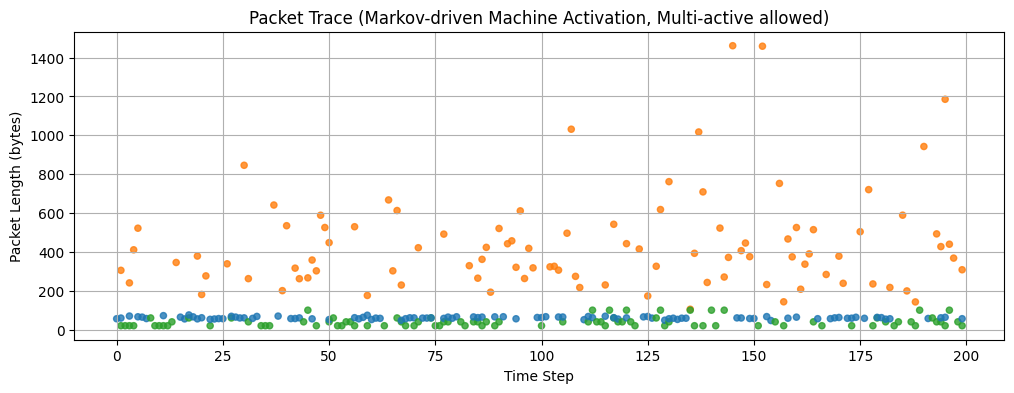

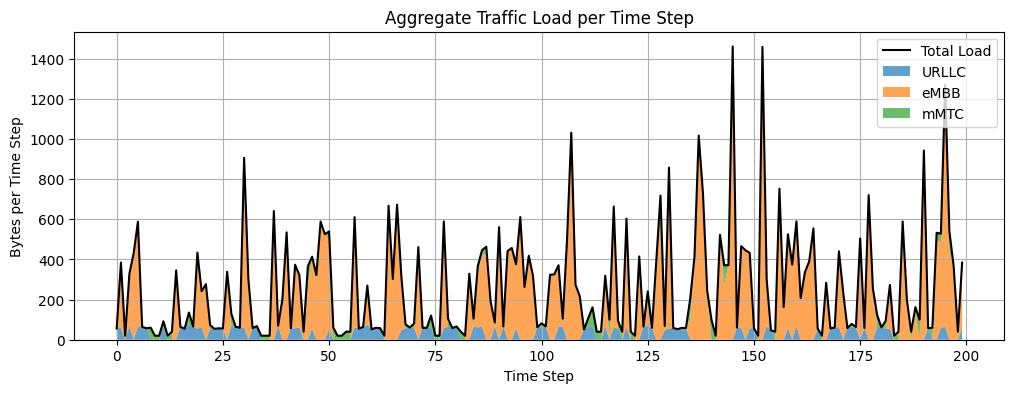

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# Configuration
# -----------------------------
np.random.seed(42)
T = 200  # number of time steps
machines = ["M1", "M2", "M3"]
profiles = {"M1": "URLLC", "M2": "eMBB", "M3": "mMTC"}

# Packet size distributions
def urlcc_packet(): return max(1, np.random.normal(60, 5))
def embb_packet(): return np.random.lognormal(mean=6, sigma=0.5)
def mmtc_packet(): return np.random.choice([20, 40, 60, 100], p=[0.4, 0.3, 0.2, 0.1])

dist_map = {"URLLC": urlcc_packet, "eMBB": embb_packet, "mMTC": mmtc_packet}
colors = {"URLLC": "tab:blue", "eMBB": "tab:orange", "mMTC": "tab:green"}

# Transition matrix for machine activity
P = np.array([
    [0.6, 0.2, 0.2],  # If at M1
    [0.2, 0.6, 0.2],  # If at M2
    [0.2, 0.2, 0.6],  # If at M3
])

# -----------------------------
# Simulate machine activity
# -----------------------------
state = 0  # start with M1
states = [state]
for t in range(1, T):
    state = np.random.choice([0, 1, 2], p=P[state])
    states.append(state)

# Allow multiple machines active
all_active = []
for s in states:
    active = {machines[s]}  # always include Markov-selected machine
    for m in machines:
        if m != machines[s] and np.random.rand() < 0.2:  # 20% chance extra
            active.add(m)
    all_active.append(active)

# -----------------------------
# Generate traffic
# -----------------------------
packet_times, packet_sizes, packet_profiles, packet_machines = [], [], [], []
for t, active_set in enumerate(all_active):
    for m in active_set:
        profile = profiles[m]
        size = dist_map[profile]()
        packet_times.append(t)
        packet_sizes.append(size)
        packet_profiles.append(profile)
        packet_machines.append(m)

# -----------------------------
# Plot packet trace
# -----------------------------
plt.figure(figsize=(12, 4))
plt.scatter(packet_times, packet_sizes, 
            c=[colors[p] for p in packet_profiles], 
            s=20, alpha=0.8)
plt.title("Packet Trace (Markov-driven Machine Activation, Multi-active allowed)")
plt.xlabel("Time Step")
plt.ylabel("Packet Length (bytes)")
plt.grid(True)
plt.show()

# -----------------------------
# Aggregate traffic per time step
# -----------------------------
df = pd.DataFrame({"time": packet_times, "size": packet_sizes, "profile": packet_profiles})
agg_total = df.groupby("time")["size"].sum()
agg_by_profile = df.groupby(["time", "profile"])["size"].sum().unstack(fill_value=0)

plt.figure(figsize=(12, 4))
plt.plot(agg_total.index, agg_total.values, color="black", linewidth=1.5, label="Total Load")
plt.stackplot(agg_by_profile.index, 
              agg_by_profile["URLLC"], 
              agg_by_profile["eMBB"], 
              agg_by_profile["mMTC"], 
              labels=["URLLC", "eMBB", "mMTC"],
              colors=["tab:blue", "tab:orange", "tab:green"], alpha=0.7)
plt.title("Aggregate Traffic Load per Time Step")
plt.xlabel("Time Step")
plt.ylabel("Bytes per Time Step")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


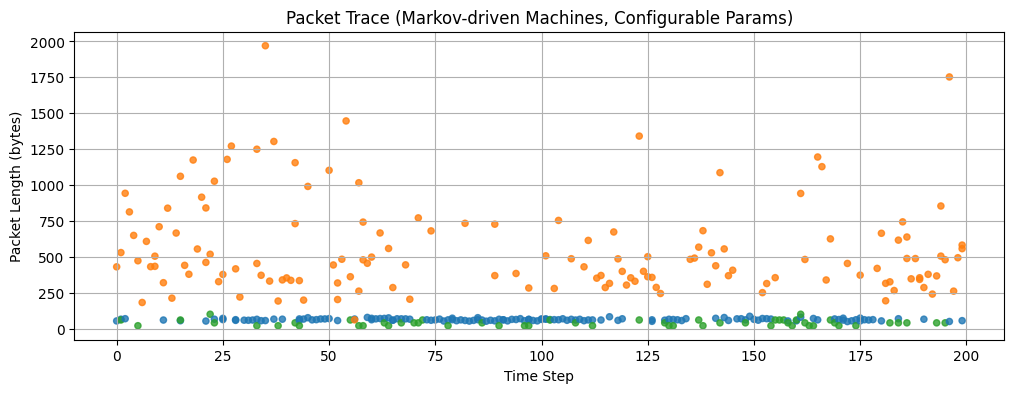

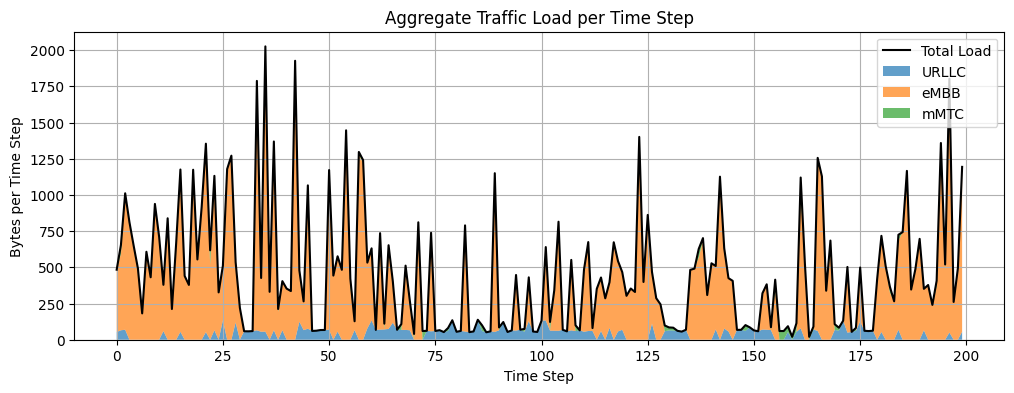

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

# -----------------------------
# Machine Configuration
# -----------------------------
machines_config = [
    {"name": "M1", "slice": "URLLC", "dist": "normal",    "mean": 60, "std": 5},
    {"name": "M2", "slice": "URLLC", "dist": "normal",    "mean": 65, "std": 7},
    {"name": "M3", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.5},
    {"name": "M4", "slice": "eMBB",  "dist": "lognormal", "mean": 6.2, "std": 0.6},
    {"name": "M5", "slice": "mMTC",  "dist": "discrete",  "values": [20,40,60,100], "probs": [0.4,0.3,0.2,0.1]},
]

# Map colors for slices
colors = {"URLLC": "tab:blue", "eMBB": "tab:orange", "mMTC": "tab:green"}

# -----------------------------
# Sampling Functions
# -----------------------------
def sample_packet(machine):
    if machine["dist"] == "normal":
        return max(1, np.random.normal(machine["mean"], machine["std"]))
    elif machine["dist"] == "lognormal":
        return np.random.lognormal(machine["mean"], machine["std"])
    elif machine["dist"] == "discrete":
        return np.random.choice(machine["values"], p=machine["probs"])
    else:
        raise ValueError("Unknown distribution type")

# -----------------------------
# Markov Chain for Activation
# -----------------------------
T = 200  # number of time steps
N = len(machines_config)

# Transition matrix (N x N), here uniform-ish persistence
P = np.full((N, N), 0.1/(N-1))  # small probability to jump
np.fill_diagonal(P, 0.9)        # high probability to stay

# Simulate active machine sequence
state = 0  # start at first machine
states = [state]
for t in range(1, T):
    state = np.random.choice(range(N), p=P[state])
    states.append(state)

# Allow multiple machines active
all_active = []
for s in states:
    active = {s}
    for m in range(N):
        if m != s and np.random.rand() < 0.15:  # 15% chance to include another machine
            active.add(m)
    all_active.append(active)

# -----------------------------
# Generate Traffic Trace
# -----------------------------
packet_times, packet_sizes, packet_slices, packet_machines = [], [], [], []

for t, active_set in enumerate(all_active):
    for m in active_set:
        machine = machines_config[m]
        size = sample_packet(machine)
        packet_times.append(t)
        packet_sizes.append(size)
        packet_slices.append(machine["slice"])
        packet_machines.append(machine["name"])

# -----------------------------
# Plot Packet Trace
# -----------------------------
plt.figure(figsize=(12,4))
plt.scatter(packet_times, packet_sizes, 
            c=[colors[s] for s in packet_slices], 
            s=20, alpha=0.8)
plt.title("Packet Trace (Markov-driven Machines, Configurable Params)")
plt.xlabel("Time Step")
plt.ylabel("Packet Length (bytes)")
plt.grid(True)
plt.show()

# -----------------------------
# Aggregate Load
# -----------------------------
df = pd.DataFrame({"time": packet_times, "size": packet_sizes, "slice": packet_slices})
agg_total = df.groupby("time")["size"].sum()
agg_by_slice = df.groupby(["time","slice"])["size"].sum().unstack(fill_value=0)

plt.figure(figsize=(12,4))
plt.plot(agg_total.index, agg_total.values, color="black", linewidth=1.5, label="Total Load")
plt.stackplot(agg_by_slice.index, 
              agg_by_slice.get("URLLC", 0), 
              agg_by_slice.get("eMBB", 0), 
              agg_by_slice.get("mMTC", 0), 
              labels=["URLLC","eMBB","mMTC"],
              colors=["tab:blue","tab:orange","tab:green"], alpha=0.7)
plt.title("Aggregate Traffic Load per Time Step")
plt.xlabel("Time Step")
plt.ylabel("Bytes per Time Step")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


### Save seperate csv files

In [ ]:
import numpy as np
import pandas as pd

# -----------------------------
# Step 1: Machine Configuration
# -----------------------------
np.random.seed(42)   # for reproducibility
T = 200              # number of time steps

machines_config = [
    {"name": "M1", "slice": "URLLC", "dist": "normal",    "mean": 60, "std": 5},
    {"name": "M2", "slice": "URLLC", "dist": "normal",    "mean": 65, "std": 7},
    {"name": "M3", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.5},
    {"name": "M4", "slice": "eMBB",  "dist": "lognormal", "mean": 6.2, "std": 0.6},
    {"name": "M5", "slice": "mMTC",  "dist": "discrete",  "values": [20,40,60,100], "probs": [0.4,0.3,0.2,0.1]},
]

# -----------------------------
# Step 2: Sampling Function
# -----------------------------
def sample_packet(machine):
    """Sample a packet size based on the machine's distribution."""
    if machine["dist"] == "normal":
        return max(1, np.random.normal(machine["mean"], machine["std"]))
    elif machine["dist"] == "lognormal":
        return np.random.lognormal(machine["mean"], machine["std"])
    elif machine["dist"] == "discrete":
        return np.random.choice(machine["values"], p=machine["probs"])
    else:
        raise ValueError("Unknown distribution type")

# -----------------------------
# Step 3: Markov Chain for Machine Activation
# -----------------------------
N = len(machines_config)

# Transition matrix: mostly stay in current machine (0.9), small chance to jump (0.1 distributed)
P = np.full((N, N), 0.1/(N-1))
np.fill_diagonal(P, 0.9)

state = 0  # start at first machine
states = [state]
for t in range(1, T):
    state = np.random.choice(range(N), p=P[state])
    states.append(state)

# Allow multiple machines active at once
all_active = []
for s in states:
    active = {s}
    for m in range(N):
        if m != s and np.random.rand() < 0.15:  # 15% chance extra machine joins
            active.add(m)
    all_active.append(active)

# -----------------------------
# Step 4: Generate Traffic
# -----------------------------
packet_times, packet_sizes, packet_slices, packet_machines = [], [], [], []

for t, active_set in enumerate(all_active):
    for m in active_set:
        machine = machines_config[m]
        size = sample_packet(machine)
        packet_times.append(t)
        packet_sizes.append(size)
        packet_slices.append(machine["slice"])
        packet_machines.append(machine["name"])

trace_df = pd.DataFrame({
    "time": packet_times,
    "machine": packet_machines,
    "slice": packet_slices,
    "packet_size": np.round(packet_sizes,2)
})

# -----------------------------
# Step 5: Save per-UE traces
# -----------------------------
for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    filename = f"{slice_type}_{machine}_trace.csv"
    group.to_csv(filename, index=False)
    print(f"Saved {filename} with {len(group)} packets")

print("✅ All traces generated and saved!")


Saved URLLC_M1_trace.csv with 68 packets
Saved URLLC_M2_trace.csv with 67 packets
Saved eMBB_M3_trace.csv with 75 packets
Saved eMBB_M4_trace.csv with 69 packets
Saved mMTC_M5_trace.csv with 54 packets
✅ All traces generated and saved!


### Considering downlink and uplink

In [4]:
import numpy as np
import pandas as pd
import random

# -----------------------------
# Step 1: Machine & Network Configuration
# -----------------------------
np.random.seed(42)
random.seed(42)

machines_config = [
    {"name": "M1", "slice": "URLLC", "dist": "normal",    "mean": 60, "std": 5, "ip": "10.0.0.1"},
    {"name": "M2", "slice": "URLLC", "dist": "normal",    "mean": 65, "std": 7, "ip": "10.0.0.2"},
    {"name": "M3", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.5, "ip": "10.0.0.3"},
    {"name": "M4", "slice": "eMBB",  "dist": "lognormal", "mean": 6.2, "std": 0.6, "ip": "10.0.0.4"},
    {"name": "M5", "slice": "mMTC",  "dist": "discrete",  "values": [20,40,60,100], "probs": [0.4,0.3,0.2,0.1], "ip": "10.0.0.5"},
]

server_ip = "192.168.0.1"   # fixed server IP

# Interarrival time distributions per slice (in ms)
interarrival = {
    "URLLC": [0.5, 1, 1.5, 2],       # very frequent
    "eMBB":  [5, 10, 20, 30],        # moderate
    "mMTC":  [50, 100, 200, 500]     # sparse
}

# Uplink probability per slice
uplink_ratio = {
    "URLLC": 0.85,   # 85% uplink, 15% downlink
    "eMBB":  0.3,    # 30% uplink, 70% downlink
    "mMTC":  0.95    # 95% uplink, 5% downlink
}

# -----------------------------
# Step 2: Sampling Functions
# -----------------------------
def sample_packet(machine):
    if machine["dist"] == "normal":
        return max(1, np.random.normal(machine["mean"], machine["std"]))
    elif machine["dist"] == "lognormal":
        return np.random.lognormal(machine["mean"], machine["std"])
    elif machine["dist"] == "discrete":
        return np.random.choice(machine["values"], p=machine["probs"])
    else:
        raise ValueError("Unknown distribution type")

def sample_interarrival(slice_type):
    return random.choice(interarrival[slice_type])

def sample_direction(machine_ip, slice_type):
    """Uplink/downlink decision per slice ratio."""
    if random.random() < uplink_ratio[slice_type]:
        return machine_ip, server_ip   # uplink
    else:
        return server_ip, machine_ip   # downlink

# -----------------------------
# Step 3: Generate Traffic
# -----------------------------
N = len(machines_config)
T = 500  # number of packet *events*

packet_times, packet_sizes, packet_slices, packet_machines = [], [], [], []
packet_src, packet_dst = [], []

current_time = 0.0
state = 0  # start with first machine

for t in range(T):
    machine = machines_config[state]

    # Advance global clock
    delta = sample_interarrival(machine["slice"])
    current_time += delta

    # Packet size
    size = sample_packet(machine)

    # Direction
    src, dst = sample_direction(machine["ip"], machine["slice"])

    # Store
    packet_times.append(current_time)
    packet_sizes.append(size)
    packet_slices.append(machine["slice"])
    packet_machines.append(machine["name"])
    packet_src.append(src)
    packet_dst.append(dst)

    # Markov chain state transition (mostly stay, small chance to switch)
    probs = np.full(N, 0.1/(N-1))
    probs[state] = 0.9
    state = np.random.choice(range(N), p=probs)

# -----------------------------
# Step 4: Save Traces per UE
# -----------------------------
trace_df = pd.DataFrame({
    "time_ms": np.round(packet_times, 3),
    "machine": packet_machines,
    "slice": packet_slices,
    "src_ip": packet_src,
    "dst_ip": packet_dst,
    "packet_size": np.round(packet_sizes, 2)
})

for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    filename = f"{slice_type}_{machine}_trace.csv"
    group.to_csv(filename, index=False)
    print(f"✅ Saved {filename} with {len(group)} packets")

print("All traces saved with slice-specific uplink/downlink ratios.")


✅ Saved URLLC_M1_trace.csv with 124 packets
✅ Saved URLLC_M2_trace.csv with 80 packets
✅ Saved eMBB_M3_trace.csv with 117 packets
✅ Saved eMBB_M4_trace.csv with 58 packets
✅ Saved mMTC_M5_trace.csv with 121 packets
All traces saved with slice-specific uplink/downlink ratios.


### Configurable duration (in ms)

✅ Saved URLLC_M1_trace.csv with 63 packets
✅ Saved URLLC_M2_trace.csv with 56 packets
✅ Saved eMBB_M3_trace.csv with 94 packets
✅ Saved eMBB_M4_trace.csv with 55 packets
✅ Saved mMTC_M5_trace.csv with 42 packets


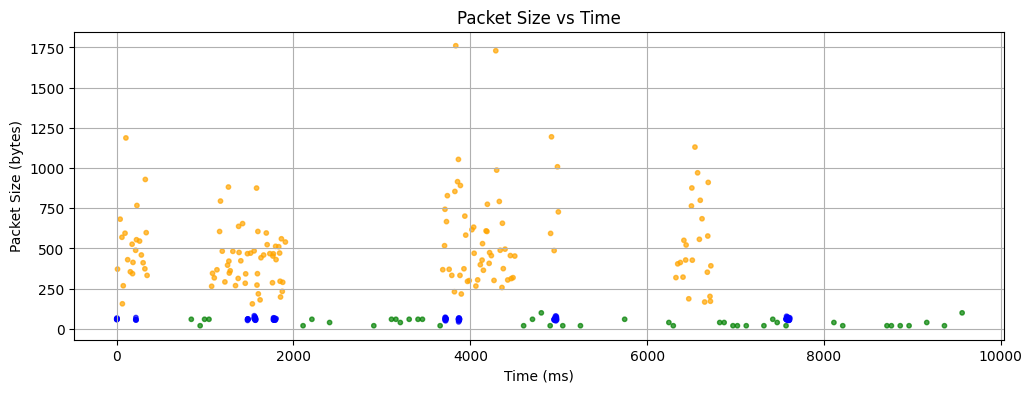

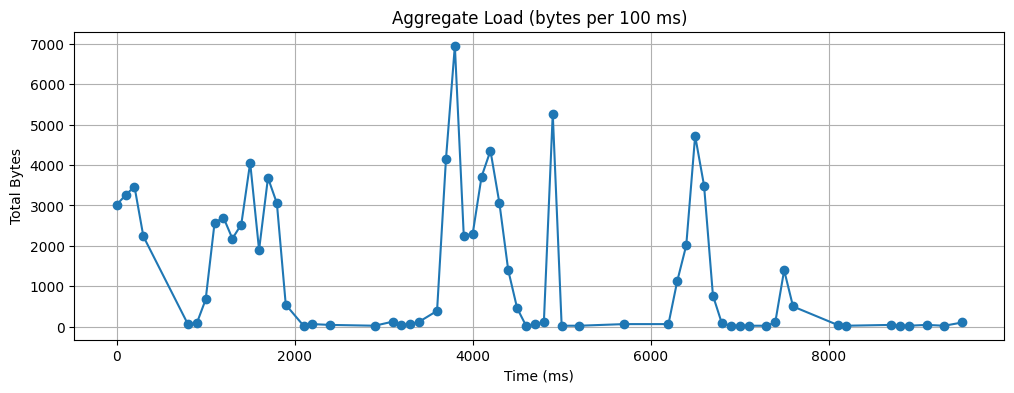

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Machine & Network Configuration
# -----------------------------
np.random.seed(42)
random.seed(42)

machines_config = [
    {"name": "M1", "slice": "URLLC", "dist": "normal",    "mean": 60, "std": 5, "ip": "10.0.0.1"},
    {"name": "M2", "slice": "URLLC", "dist": "normal",    "mean": 65, "std": 7, "ip": "10.0.0.2"},
    {"name": "M3", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.5, "ip": "10.0.0.3"},
    {"name": "M4", "slice": "eMBB",  "dist": "lognormal", "mean": 6.2, "std": 0.6, "ip": "10.0.0.4"},
    {"name": "M5", "slice": "mMTC",  "dist": "discrete",  "values": [20,40,60,100], "probs": [0.4,0.3,0.2,0.1], "ip": "10.0.0.5"},
]

server_ip = "192.168.0.1"

# Interarrival time distributions (ms)
interarrival = {
    "URLLC": [0.5, 1, 1.5, 2],
    "eMBB":  [5, 10, 20, 30],
    "mMTC":  [50, 100, 200, 500]
}

# Uplink probability per slice
uplink_ratio = {
    "URLLC": 0.85,
    "eMBB":  0.3,
    "mMTC":  0.95
}

# -----------------------------
# Step 2: Sampling Functions
# -----------------------------
def sample_packet(machine):
    if machine["dist"] == "normal":
        return max(1, np.random.normal(machine["mean"], machine["std"]))
    elif machine["dist"] == "lognormal":
        return np.random.lognormal(machine["mean"], machine["std"])
    elif machine["dist"] == "discrete":
        return np.random.choice(machine["values"], p=machine["probs"])
    else:
        raise ValueError("Unknown distribution type")

def sample_interarrival(slice_type):
    return random.choice(interarrival[slice_type])

def sample_direction(machine_ip, slice_type):
    if random.random() < uplink_ratio[slice_type]:
        return machine_ip, server_ip   # uplink
    else:
        return server_ip, machine_ip   # downlink

# -----------------------------
# Step 3: Generate Traffic
# -----------------------------
N = len(machines_config)
sim_duration = 10_000   # simulate for 10 seconds (in ms)

packet_times, packet_sizes, packet_slices, packet_machines = [], [], [], []
packet_src, packet_dst = [], []

current_time = 0.0
state = 0

while current_time < sim_duration:
    machine = machines_config[state]

    # advance time
    delta = sample_interarrival(machine["slice"])
    current_time += delta
    if current_time > sim_duration:
        break

    # packet info
    size = sample_packet(machine)
    src, dst = sample_direction(machine["ip"], machine["slice"])

    # store
    packet_times.append(current_time)
    packet_sizes.append(size)
    packet_slices.append(machine["slice"])
    packet_machines.append(machine["name"])
    packet_src.append(src)
    packet_dst.append(dst)

    # Markov step
    probs = np.full(N, 0.1/(N-1))
    probs[state] = 0.9
    state = np.random.choice(range(N), p=probs)

# -----------------------------
# Step 4: Save per UE traces
# -----------------------------
trace_df = pd.DataFrame({
    "time_ms": np.round(packet_times, 3),
    "machine": packet_machines,
    "slice": packet_slices,
    "src_ip": packet_src,
    "dst_ip": packet_dst,
    "packet_size": np.round(packet_sizes, 2)
})

for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    filename = f"{slice_type}_{machine}_trace.csv"
    group.to_csv(filename, index=False)
    print(f"✅ Saved {filename} with {len(group)} packets")

# -----------------------------
# Step 5: Plots
# -----------------------------
# Scatter plot of packet sizes
plt.figure(figsize=(12,4))
colors = {"URLLC":"blue", "eMBB":"orange", "mMTC":"green"}
plt.scatter(trace_df["time_ms"], trace_df["packet_size"], 
            c=[colors[s] for s in trace_df["slice"]], s=10, alpha=0.7)
plt.title("Packet Size vs Time")
plt.xlabel("Time (ms)")
plt.ylabel("Packet Size (bytes)")
plt.grid(True)
plt.show()

# Aggregate traffic load per 100 ms
bin_size = 100
trace_df["time_bin"] = (trace_df["time_ms"] // bin_size) * bin_size
agg = trace_df.groupby("time_bin")["packet_size"].sum()

plt.figure(figsize=(12,4))
plt.plot(agg.index, agg.values, marker="o")
plt.title(f"Aggregate Load (bytes per {bin_size} ms)")
plt.xlabel("Time (ms)")
plt.ylabel("Total Bytes")
plt.grid(True)
plt.show()


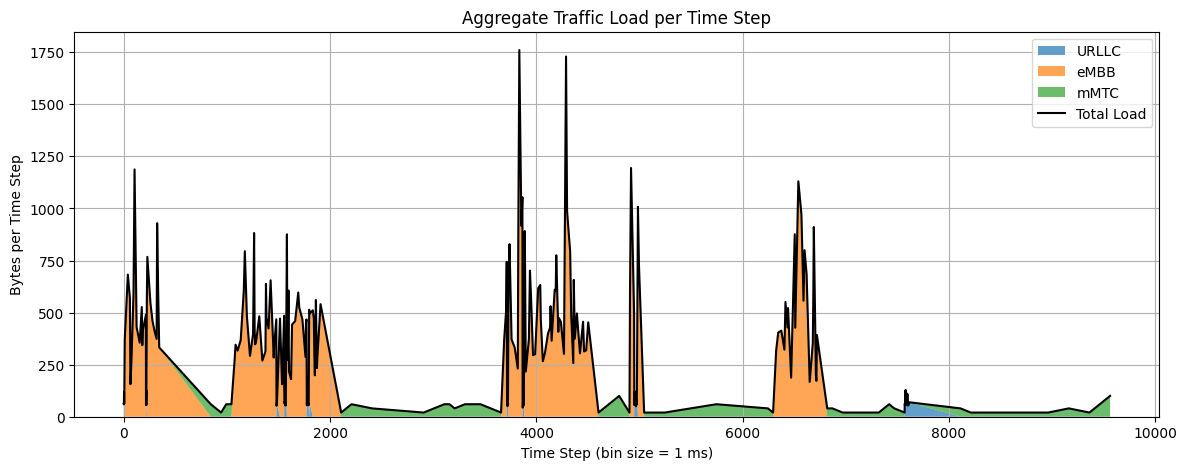

In [2]:
# -----------------------------
# Step 6: Stacked Area Plot (like your example)
# -----------------------------
# First, group traffic per slice and time bin
bin_size = 1  # here 1 ms bins, you can adjust to 10, 50, 100, etc.
trace_df["time_bin"] = (trace_df["time_ms"] // bin_size).astype(int)

# Pivot into slice-wise traffic
pivot = trace_df.pivot_table(values="packet_size", 
                             index="time_bin", 
                             columns="slice", 
                             aggfunc="sum", 
                             fill_value=0)

# Add total load
pivot["Total"] = pivot.sum(axis=1)

# Plot
plt.figure(figsize=(14,5))
plt.stackplot(pivot.index, 
              pivot.get("URLLC", pd.Series(0, index=pivot.index)),
              pivot.get("eMBB", pd.Series(0, index=pivot.index)),
              pivot.get("mMTC", pd.Series(0, index=pivot.index)),
              labels=["URLLC","eMBB","mMTC"], alpha=0.7)

# Add total load as a black line
plt.plot(pivot.index, pivot["Total"], color="black", linewidth=1.5, label="Total Load")

plt.title("Aggregate Traffic Load per Time Step")
plt.xlabel("Time Step (bin size = {} ms)".format(bin_size))
plt.ylabel("Bytes per Time Step")
plt.legend()
plt.grid(True)
plt.show()


### make more than one machine active at a time

Saved URLLC_M1_trace.csv (827 packets)
Saved URLLC_M2_trace.csv (589 packets)
Saved eMBB_M3_trace.csv (230 packets)
Saved eMBB_M4_trace.csv (183 packets)
Saved mMTC_M5_trace.csv (194 packets)
Saved all_traces.csv (2023 packets total)


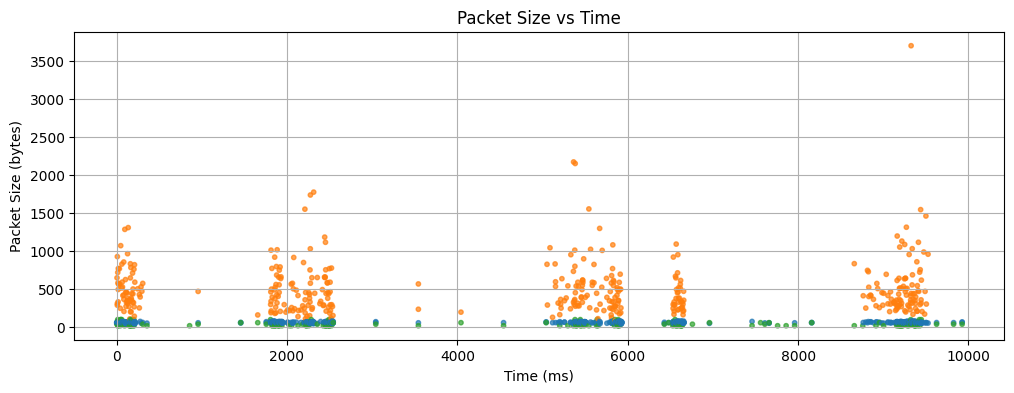

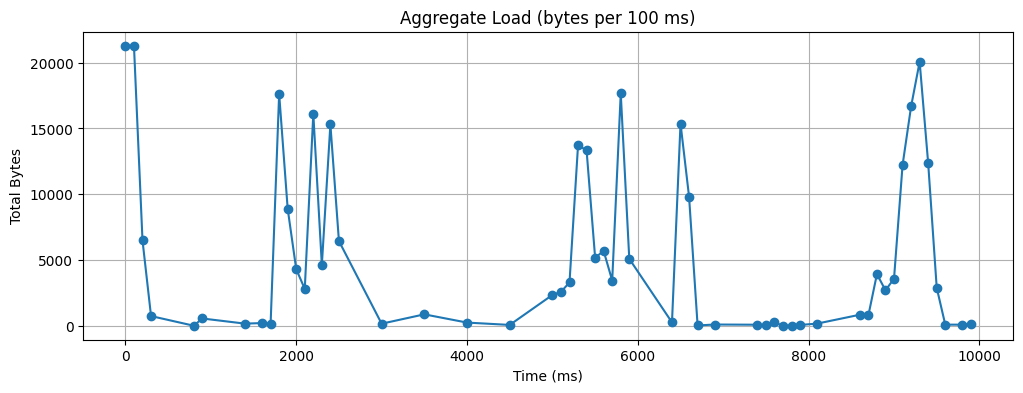

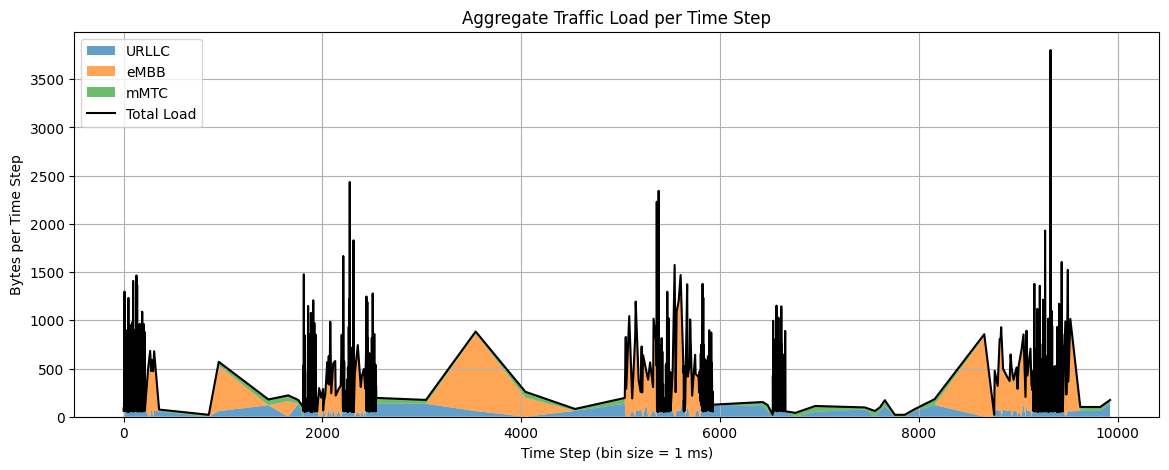

In [7]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# =============================
# Config
# =============================
np.random.seed(11)
random.seed(11)

# Define your machines (UEs) — means/stds are per-machine even within the same slice
machines_config = [
    {"name": "M1", "slice": "URLLC", "dist": "normal",    "mean": 60,  "std": 5,  "ip": "10.0.0.1"},
    {"name": "M2", "slice": "URLLC", "dist": "normal",    "mean": 65,  "std": 7,  "ip": "10.0.0.2"},
    {"name": "M3", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.5,"ip": "10.0.0.3"},
    {"name": "M4", "slice": "eMBB",  "dist": "lognormal", "mean": 6.2, "std": 0.6,"ip": "10.0.0.4"},
    {"name": "M5", "slice": "mMTC",  "dist": "discrete",  "values": [20,40,60,100], "probs": [0.4,0.3,0.2,0.1], "ip": "10.0.0.5"},
]

# Interarrival distributions per slice (milliseconds)
interarrival_ms = {
    "URLLC": [0.5, 1, 1.5, 2],     # very frequent
    "eMBB":  [5, 10, 20, 30],      # moderate
    "mMTC":  [50, 100, 200, 500],  # sparse
}

# Uplink probability per slice (probability that direction is UE->Server)
uplink_ratio = {
    "URLLC": 0.20,
    "eMBB":  0.30,
    "mMTC":  0.95,
}

# Probability that an additional machine joins as "secondary" active machine this event
p_extra_base = 0.15  # baseline chance
p_extra_urlcc_boost = 2.0  # URLLC machines have higher chance: p_extra_base * boost

# Simulation duration (ms) and plotting bin
sim_duration_ms = 10_000
plot_bin_ms = 100  # for aggregate line plot; stacked area uses 1 ms by default

# Server IP
server_ip = "192.168.0.1"

# =============================
# Sampling helpers
# =============================
def sample_packet(machine):
    if machine["dist"] == "normal":
        return max(1.0, float(np.random.normal(machine["mean"], machine["std"])))
    elif machine["dist"] == "lognormal":
        # lognormal uses mean, std in log-space
        return float(np.random.lognormal(machine["mean"], machine["std"]))
    elif machine["dist"] == "discrete":
        return float(np.random.choice(machine["values"], p=machine["probs"]))
    else:
        raise ValueError("Unknown dist: " + str(machine["dist"]))

def sample_interarrival(slice_type):
    return float(random.choice(interarrival_ms[slice_type]))

def sample_direction(machine_ip, slice_type):
    if random.random() < uplink_ratio[slice_type]:
        return "UL", machine_ip, server_ip
    else:
        return "DL", server_ip, machine_ip

# =============================
# Biased Markov: primary machine
# =============================
def biased_transition_probs(state_idx, machines):
    """
    URLLC gets high persistence and higher incoming probability.
    Non-URLLC has lower persistence and smaller cross-probabilities.
    """
    N = len(machines)
    probs = np.zeros(N, dtype=float)
    current_slice = machines[state_idx]["slice"]
    if current_slice == "URLLC":
        # Very sticky URLLC
        probs[state_idx] = 0.98
        others = [i for i in range(N) if i != state_idx]
        if others:
            jump = 0.02 / len(others)
            for i in others:
                probs[i] = jump
    else:
        # Less sticky for others
        probs[state_idx] = 0.85
        others = [i for i in range(N) if i != state_idx]
        if others:
            # split remaining among URLLC and non-URLLC targets with a bias toward URLLC
            urlcc_targets = [i for i in others if machines[i]["slice"] == "URLLC"]
            other_targets = [i for i in others if machines[i]["slice"] != "URLLC"]
            mass_to_urlcc = 0.10
            mass_to_others = 0.05
            if urlcc_targets:
                for i in urlcc_targets:
                    probs[i] = mass_to_urlcc / len(urlcc_targets)
            if other_targets:
                for i in other_targets:
                    probs[i] = mass_to_others / len(other_targets)
    # numerical safety
    probs = probs / probs.sum()
    return probs

def biased_active_set(primary_idx, machines, p_extra=p_extra_base):
    """
    Decide which machines are active this event.
    Always include primary. Others can join; URLLC machines are more likely.
    """
    N = len(machines)
    active = {primary_idx}
    for i in range(N):
        if i == primary_idx:
            continue
        join_prob = p_extra
        if machines[i]["slice"] == "URLLC":
            join_prob *= p_extra_urlcc_boost
        if random.random() < join_prob:
            active.add(i)
    return active

# =============================
# Simulation
# =============================
packet_rows = []
current_time = 0.0
N = len(machines_config)
state = 0  # start from first machine

while current_time < sim_duration_ms:
    # Choose primary machine via biased Markov
    probs = biased_transition_probs(state, machines_config)
    state = int(np.random.choice(range(N), p=probs))

    # Build active set (primary + optional others)
    active_set = biased_active_set(state, machines_config)

    # Advance clock using the primary machine's slice interarrival
    delta = sample_interarrival(machines_config[state]["slice"])
    current_time += delta
    if current_time > sim_duration_ms:
        break

    # Generate one packet for each active machine at this timestamp
    for m_idx in active_set:
        m = machines_config[m_idx]
        size = sample_packet(m)
        direction, src_ip, dst_ip = sample_direction(m["ip"], m["slice"])
        packet_rows.append({
            "time_ms": round(current_time, 3),
            "machine": m["name"],
            "slice": m["slice"],
            "direction": direction,     # "UL" or "DL"
            "src_ip": src_ip,
            "dst_ip": dst_ip,
            "packet_size": round(size, 2),
        })

# =============================
# DataFrame + CSVs
# =============================
trace_df = pd.DataFrame(packet_rows)
trace_df = trace_df.sort_values(["time_ms", "machine"]).reset_index(drop=True)

# Save per-UE CSVs (slice_machine_trace.csv)
for (slice_type, machine), grp in trace_df.groupby(["slice", "machine"]):
    fname = f"{slice_type}_{machine}_trace.csv"
    grp.to_csv(fname, index=False)
    print(f"Saved {fname} ({len(grp)} packets)")

# Also save combined CSV
trace_df.to_csv("all_traces.csv", index=False)
print(f"Saved all_traces.csv ({len(trace_df)} packets total)")

# =============================
# Plots
# =============================

# 1) Packet size vs time (scatter)
plt.figure(figsize=(12, 4))
color_map = {"URLLC": "tab:blue", "eMBB": "tab:orange", "mMTC": "tab:green"}
plt.scatter(
    trace_df["time_ms"],
    trace_df["packet_size"],
    c=[color_map[s] for s in trace_df["slice"]],
    s=10, alpha=0.7
)
plt.title("Packet Size vs Time")
plt.xlabel("Time (ms)")
plt.ylabel("Packet Size (bytes)")
plt.grid(True)
plt.show()

# 2) Aggregate load line plot (bytes per plot_bin_ms)
trace_df["time_bin"] = (trace_df["time_ms"] // plot_bin_ms) * plot_bin_ms
agg = trace_df.groupby("time_bin")["packet_size"].sum()
plt.figure(figsize=(12, 4))
plt.plot(agg.index, agg.values, marker="o")
plt.title(f"Aggregate Load (bytes per {int(plot_bin_ms)} ms)")
plt.xlabel("Time (ms)")
plt.ylabel("Total Bytes")
plt.grid(True)
plt.show()

# 3) Stacked area per slice + total line (1 ms bins for a fine-grained view)
bin_size_sa = 1  # 1 ms
trace_df["time_bin_sa"] = (trace_df["time_ms"] // bin_size_sa).astype(int)
pivot = trace_df.pivot_table(
    index="time_bin_sa", columns="slice", values="packet_size",
    aggfunc="sum", fill_value=0
).sort_index()

for s in ["URLLC", "eMBB", "mMTC"]:  # ensure all columns exist
    if s not in pivot.columns:
        pivot[s] = 0

pivot["Total"] = pivot[["URLLC", "eMBB", "mMTC"]].sum(axis=1)

plt.figure(figsize=(14, 5))
plt.stackplot(
    pivot.index,
    pivot["URLLC"], pivot["eMBB"], pivot["mMTC"],
    labels=["URLLC", "eMBB", "mMTC"], alpha=0.7
)
plt.plot(pivot.index, pivot["Total"], color="black", linewidth=1.5, label="Total Load")
plt.title("Aggregate Traffic Load per Time Step")
plt.xlabel(f"Time Step (bin size = {bin_size_sa} ms)")
plt.ylabel("Bytes per Time Step")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# 1. Build timeline from union of all unique times across machines
all_times = pd.Series(sorted(trace_df["time_ms"].unique()))
timeline = pd.DataFrame({"time_ms": all_times})

# 2. For each machine, align to global timeline
for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    # Merge with global timeline (keeps original float timestamps)
    df = pd.merge(timeline, group, on="time_ms", how="left")

    # Fill missing packet sizes with 0
    df["packet_size"] = df["packet_size"].fillna(0).astype(int)

    # Fill other metadata forward/backward so rows stay valid
    for col in df.columns:
        if col not in ["time_ms", "packet_size"]:
            df[col] = df[col].fillna(method="ffill").fillna(method="bfill")

    # Save aligned trace
    fname = f"{slice_type}_{machine}_aligned_trace.csv"
    df.to_csv(fname, index=False)
    print(f"Saved {fname} with {len(df)} rows (aligned, event-driven)")


Saved URLLC_M1_aligned_trace.csv with 1149 rows (aligned, event-driven)
Saved URLLC_M2_aligned_trace.csv with 1149 rows (aligned, event-driven)
Saved eMBB_M3_aligned_trace.csv with 1149 rows (aligned, event-driven)
Saved eMBB_M4_aligned_trace.csv with 1149 rows (aligned, event-driven)
Saved mMTC_M5_aligned_trace.csv with 1149 rows (aligned, event-driven)


/tmp/ipykernel_373203/2481319621.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_373203/2481319621.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_373203/2481319621.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_373203/2481319621.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_373203/2481319621.py:16: Futu

In [ ]:
import random

# 1. Determine global time axis
max_time = int(trace_df["time_ms"].max())
time_axis = pd.Series(range(0, max_time+1))  # every ms

# 2. For each machine, reindex on the global timeline
for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    # Use time as index
    df = group.set_index("time_ms").sort_index()

    # Reindex to full time axis, filling missing with 0
    df = df.reindex(time_axis, method=None, fill_value=0)

    # Restore time column
    df = df.reset_index().rename(columns={"index": "time_ms"})

    # Machine and slice fixed
    df["machine"] = machine
    df["slice"] = slice_type

    # Fill direction randomly when it was missing
    directions = ["UL", "DL"]
    df["direction"] = df["direction"].apply(lambda x: x if x != 0 else random.choice(directions))

    # Fill IPs randomly from the correct config
    machine_ip = machines_config[[m["name"] for m in machines_config].index(machine)]["ip"]
    server_ip = "192.168.0.1"
    def fill_ips(row):
        if row["direction"] == "UL":
            return machine_ip, server_ip
        else:
            return server_ip, machine_ip
    df[["src_ip", "dst_ip"]] = df.apply(
        lambda row: fill_ips(row) if row["src_ip"] == 0 or row["dst_ip"] == 0 else (row["src_ip"], row["dst_ip"]),
        axis=1, result_type="expand"
    )

    # Save per-machine
    fname = f"{slice_type}_{machine}_aligned_trace.csv"
    df.to_csv(fname, index=False)
    print(f"Saved {fname} with {len(df)} rows (aligned to {max_time} ms)")


Saved URLLC_M1_aligned_trace.csv with 9926 rows (aligned to 9925 ms)
Saved URLLC_M2_aligned_trace.csv with 9926 rows (aligned to 9925 ms)
Saved eMBB_M3_aligned_trace.csv with 9926 rows (aligned to 9925 ms)
Saved eMBB_M4_aligned_trace.csv with 9926 rows (aligned to 9925 ms)
Saved mMTC_M5_aligned_trace.csv with 9926 rows (aligned to 9925 ms)


In [11]:
# 1. Determine global time axis
max_time = int(trace_df["time_ms"].max())
time_axis = pd.Series(range(0, max_time+1))  # every ms, or step size of your choice

# 2. For each machine, reindex on the global timeline
for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    # Use time as index
    df = group.set_index("time_ms").sort_index()

    # Reindex to full time axis, filling missing with 0
    df = df.reindex(time_axis, method=None, fill_value=0)

    # Restore time column
    df = df.reset_index().rename(columns={"index": "time_ms"})

    # If you want to keep columns for src/dst/direction but mark idle slots:
    df["machine"].replace(0, machine, inplace=True)
    df["slice"].replace(0, slice_type, inplace=True)
    df["direction"] = df["direction"].replace(0, "IDLE")
    df["src_ip"] = df["src_ip"].replace(0, "")
    df["dst_ip"] = df["dst_ip"].replace(0, "")

    # Save per-machine
    fname = f"{slice_type}_{machine}_aligned_trace.csv"
    df.to_csv(fname, index=False)
    print(f"Saved {fname} with {len(df)} rows (aligned to {max_time} ms)")


Saved URLLC_M1_aligned_trace.csv with 9926 rows (aligned to 9925 ms)
Saved URLLC_M2_aligned_trace.csv with 9926 rows (aligned to 9925 ms)
Saved eMBB_M3_aligned_trace.csv with 9926 rows (aligned to 9925 ms)
Saved eMBB_M4_aligned_trace.csv with 9926 rows (aligned to 9925 ms)
Saved mMTC_M5_aligned_trace.csv with 9926 rows (aligned to 9925 ms)


/tmp/ipykernel_3666462/2390117431.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["machine"].replace(0, machine, inplace=True)
/tmp/ipykernel_3666462/2390117431.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [ ]:
max_time = int(trace_df["time_ms"].max())
time_axis = pd.DataFrame({"time_ms": range(0, max_time+1)})



for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    df = time_axis.merge(group, on="time_ms", how="left")
    df["machine"]   = machine
    df["slice"]     = slice_type
    df["packet_size"] = df["packet_size"].fillna(0)
    df["direction"]   = df["direction"].fillna("IDLE")
    df["src_ip"]      = df["src_ip"].fillna("")
    df["dst_ip"]      = df["dst_ip"].fillna("")
    
    fname = f"{slice_type}_{machine}_aligned_trace.csv"
    df.to_csv(fname, index=False)
    print(f"Saved {fname} with {len(df)} rows")


Saved URLLC_M1_aligned_trace.csv with 9926 rows
Saved URLLC_M2_aligned_trace.csv with 9926 rows
Saved eMBB_M3_aligned_trace.csv with 9926 rows
Saved eMBB_M4_aligned_trace.csv with 9926 rows
Saved mMTC_M5_aligned_trace.csv with 9926 rows


/tmp/ipykernel_3666462/633713543.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = time_axis.merge(group, on="time_ms", how="left")
/tmp/ipykernel_3666462/633713543.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = time_axis.merge(group, on="time_ms", how="left")
/tmp/ipykernel_3666462/633713543.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = time_axis.merge(group, on="time_ms", how="left")
/tmp/ipykernel_3666462/633713543.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = time_axis.merge(group, on="time_ms", how="left")
/tmp/ipykernel_3666462/633713543.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their i

In [13]:
def align_and_fill(df, timeline, time_col="time_ms", size_col="packet_size"):
    merged = pd.merge(timeline, df, left_on=time_col, right_on=time_col, how="left")
    
    # Fill missing packet sizes with 0
    if size_col in merged.columns:
        merged[size_col] = merged[size_col].fillna(0).astype(int)
    
    # For metadata, you have two choices:
    # (1) leave them blank or set to IDLE
    for col in merged.columns:
        if col not in [time_col, size_col]:
            if col == "direction":
                merged[col] = merged[col].fillna("IDLE")
            elif col in ["src_ip", "dst_ip"]:
                merged[col] = merged[col].fillna("")
            else:
                merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
    
    return merged


In [14]:
# Build global timeline (0..max_time ms, or union of unique times if event-driven)
timeline = pd.DataFrame({"time_ms": range(0, int(trace_df["time_ms"].max())+1)})

# Align per slice/machine
for (slice_type, machine), group in trace_df.groupby(["slice","machine"]):
    aligned = align_and_fill(group, timeline)
    fname = f"{slice_type}_{machine}_aligned.csv"
    aligned.to_csv(fname, index=False)
    print(f"Saved {fname} with {len(aligned)} rows")


Saved URLLC_M1_aligned.csv with 9926 rows
Saved URLLC_M2_aligned.csv with 9926 rows
Saved eMBB_M3_aligned.csv with 9926 rows
Saved eMBB_M4_aligned.csv with 9926 rows
Saved mMTC_M5_aligned.csv with 9926 rows


/tmp/ipykernel_3666462/3199027266.py:2: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = pd.merge(timeline, df, left_on=time_col, right_on=time_col, how="left")
/tmp/ipykernel_3666462/3199027266.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_3666462/3199027266.py:2: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = pd.merge(timeline, df, left_on=time_col, right_on=time_col, how="left")
/tmp/ipykernel_3666462/3199027266.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_366

In [15]:
def align_and_fill(df, timeline, time_col="time_ms", size_col="packet_size"):
    # Merge with full timeline
    merged = pd.merge(timeline, df, on=time_col, how="left")

    # Fill packet size (traffic) with 0
    if size_col in merged.columns:
        merged[size_col] = merged[size_col].fillna(0).astype(int)

    # Fill other metadata forward/backward
    for col in merged.columns:
        if col not in [time_col, size_col]:
            merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")

    return merged


In [16]:
# Build global timeline from union of all times (event-driven, compact)
all_times = trace_df["time_ms"].drop_duplicates().sort_values().reset_index(drop=True)
timeline = pd.DataFrame({"time_ms": all_times})

# Align per machine
for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    aligned = align_and_fill(group, timeline)
    fname = f"{slice_type}_{machine}_aligned.csv"
    aligned.to_csv(fname, index=False)
    print(f"Saved {fname} with {len(aligned)} rows")


Saved URLLC_M1_aligned.csv with 1149 rows
Saved URLLC_M2_aligned.csv with 1149 rows
Saved eMBB_M3_aligned.csv with 1149 rows
Saved eMBB_M4_aligned.csv with 1149 rows
Saved mMTC_M5_aligned.csv with 1149 rows


/tmp/ipykernel_3666462/786032440.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_3666462/786032440.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_3666462/786032440.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_3666462/786032440.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykern